<a href="https://colab.research.google.com/github/Tom-Yuen/TomY_Little_Projects/blob/main/UK_Fuel_Poverty_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This project aims to look into the latest Fuel Poverty Dataset released by gov in April 2024. For example, we want to see if there's a significant difference between different regions or LA. We also want to look into the South West regions and draw some insights.
## Read the file from the gov.uk site instead of downloading it into local machine.
## Quick clean up, delete top rows to get the table we need, and delete unrelated rows.

In [17]:
import pandas as pd

# URL of the Excel file
url = "https://assets.publishing.service.gov.uk/media/663a29608603389a07a6d1b4/2024_Sub-Regional_Tables_Final.xlsx"

# Read the Excel file, skip the first 2 rows, and use the third row as header
df = pd.read_excel(url, sheet_name="Table 3", skiprows=2, header=0)

# Drop the row where 'LSOA' column has the value 'Back to contents'
df = df[df['LSOA Code'] != 'Back to contents']

# Drop the row where 'Proportion of households fuel poor (%)' is 'England'
df = df[df['Proportion of households fuel poor (%)'] != 'England']

# Display the DataFrame
print(df)


       LSOA Code           LSOA Name    LA Code        LA Name      Region  \
0      E01020634  County Durham 001A  E06000047  County Durham  North East   
1      E01020635  County Durham 001B  E06000047  County Durham  North East   
2      E01020636  County Durham 001C  E06000047  County Durham  North East   
3      E01020654  County Durham 001D  E06000047  County Durham  North East   
4      E01020676  County Durham 001E  E06000047  County Durham  North East   
...          ...                 ...        ...            ...         ...   
33751  E01034556      Wiltshire 066B  E06000054      Wiltshire  South West   
33752  E01032697      Wiltshire 066C  E06000054      Wiltshire  South West   
33753  E01034557      Wiltshire 066D  E06000054      Wiltshire  South West   
33754  E01034558      Wiltshire 066E  E06000054      Wiltshire  South West   
33756        NaN                 NaN        NaN            NaN         NaN   

       Number of households  Number of households in fuel pover

In [18]:
# Group by the 'Region' column and sum up the relevant columns
grouped_df = df.groupby("Region").agg({
    "Number of households": "sum",
    "Number of households in fuel poverty": "sum"
}).reset_index()

# Add a new column for the percentage in fuel poverty
grouped_df["% in fuel poverty"] = (grouped_df["Number of households in fuel poverty"] / grouped_df["Number of households"]) * 100

# Display the grouped DataFrame
print(grouped_df)


                     Region  Number of households  \
0             East Midlands             2110928.0   
1           East of England             2687733.0   
2                    London             3683167.0   
3                North East             1203514.0   
4                North West             3242792.0   
5                South East             3921544.0   
6                South West             2563587.0   
7             West Midlands             2514178.0   
8  Yorkshire and The Humber             2400499.0   

   Number of households in fuel poverty  % in fuel poverty  
0                              317789.0          15.054469  
1                              269281.0          10.018890  
2                              383768.0          10.419511  
3                              131122.0          10.894929  
4                              458323.0          14.133592  
5                              381503.0           9.728388  
6                              330669.0   

## We did an ANOVA test below. Somehow we found that ANOVA is not suitable for this because we have grouped by Region, and each region only get one poverty percentage. We try to look into something else.

In [19]:
import scipy.stats as stats

# Prepare lists of percentages for each region
regions = grouped_df['Region'].unique()
data_lists = [grouped_df[grouped_df['Region'] == region]['% in fuel poverty'].values for region in regions]

# Perform ANOVA test
f_stat, p_value = stats.f_oneway(*data_lists)

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("There is a significant difference in the percentage of households in fuel poverty across regions.")
else:
    print("There is no significant difference in the percentage of households in fuel poverty across regions.")


F-statistic: nan
P-value: nan
There is no significant difference in the percentage of households in fuel poverty across regions.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if _f_oneway_is_too_small(samples):


## Let's plot it in graph and see the data first. We can see that West-Midland is having much higher %, followed by Yorkshire and The Humber.

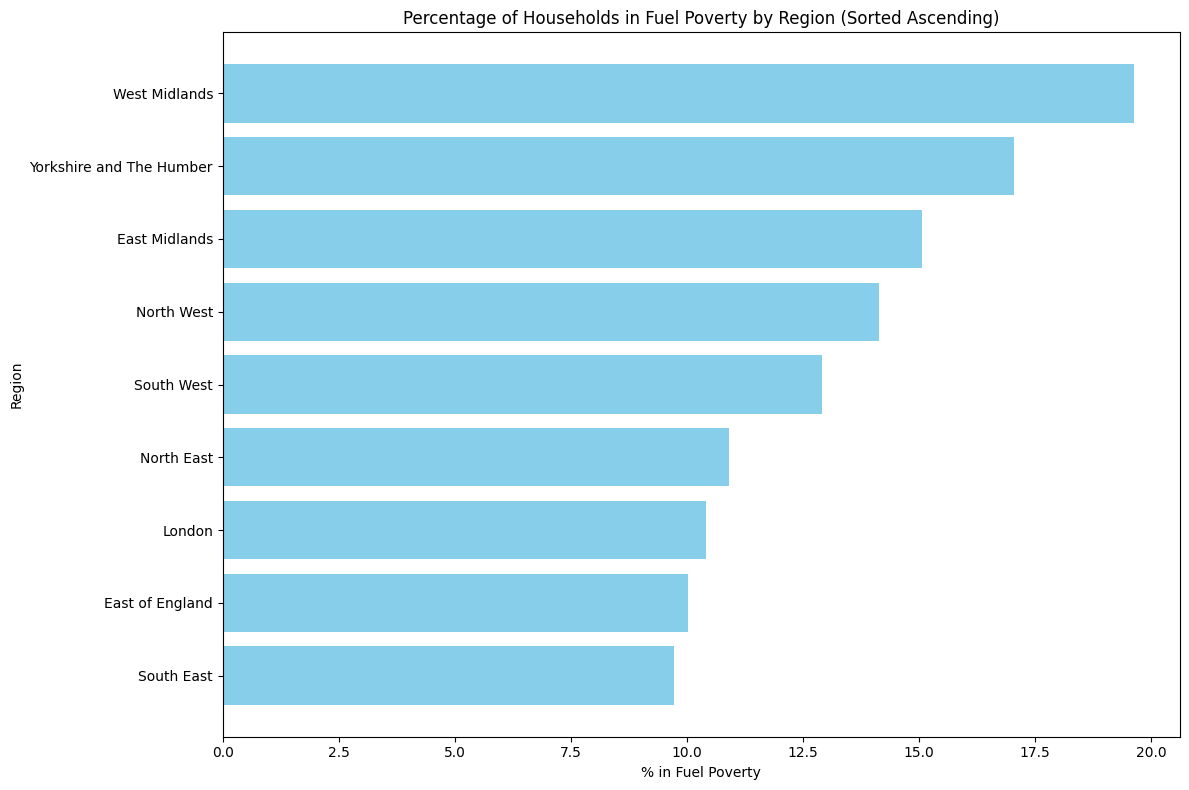

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Sort the DataFrame by '% in fuel poverty' in ascending order
sorted_df = grouped_df.sort_values(by='% in fuel poverty')

# Plot using matplotlib
plt.figure(figsize=(12, 8))
plt.barh(sorted_df['Region'], sorted_df['% in fuel poverty'], color='skyblue')

# Add labels and title
plt.xlabel('% in Fuel Poverty')
plt.ylabel('Region')
plt.title('Percentage of Households in Fuel Poverty by Region (Sorted Ascending)')
plt.tight_layout()

# Show the plot
plt.show()


In [21]:
import matplotlib.pyplot as plt

# Extract the column of interest and remove missing values
fuel_poor_percentages = df['Proportion of households fuel poor (%)'].dropna()

# See the data first
print(fuel_poor_percentages)

0         8.309859
1         7.594937
2        10.278114
3          7.94621
4        11.731044
           ...    
33750        7.785
33751       10.849
33752        7.332
33753       11.065
33754        5.882
Name: Proportion of households fuel poor (%), Length: 33755, dtype: object


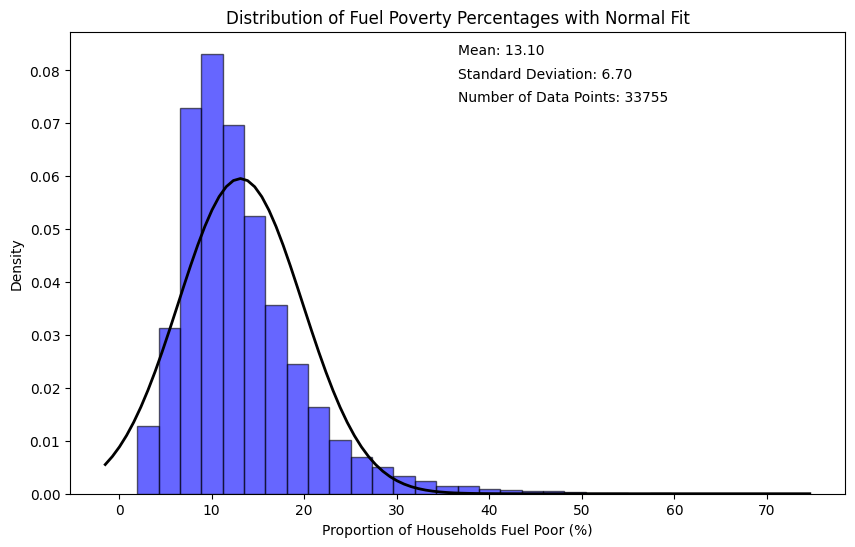

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Extract the column of interest
fuel_poor_percentages = df['Proportion of households fuel poor (%)']

# Convert the column to numeric, coercing errors to NaN
fuel_poor_percentages = pd.to_numeric(fuel_poor_percentages, errors='coerce')

# Drop missing values (NaN)
fuel_poor_percentages = fuel_poor_percentages.dropna()

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(fuel_poor_percentages, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')

# Fit a normal distribution to the data
mu, std = norm.fit(fuel_poor_percentages)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Add labels and title
plt.xlabel('Proportion of Households Fuel Poor (%)')
plt.ylabel('Density')
plt.title('Distribution of Fuel Poverty Percentages with Normal Fit')

# Display mean and standard deviation
plt.text(0.5, 0.95, f'Mean: {mu:.2f}', transform=plt.gca().transAxes)
plt.text(0.5, 0.90, f'Standard Deviation: {std:.2f}', transform=plt.gca().transAxes)
plt.text(0.5, 0.85, f'Number of Data Points: {len(fuel_poor_percentages)}', transform=plt.gca().transAxes)


plt.show()

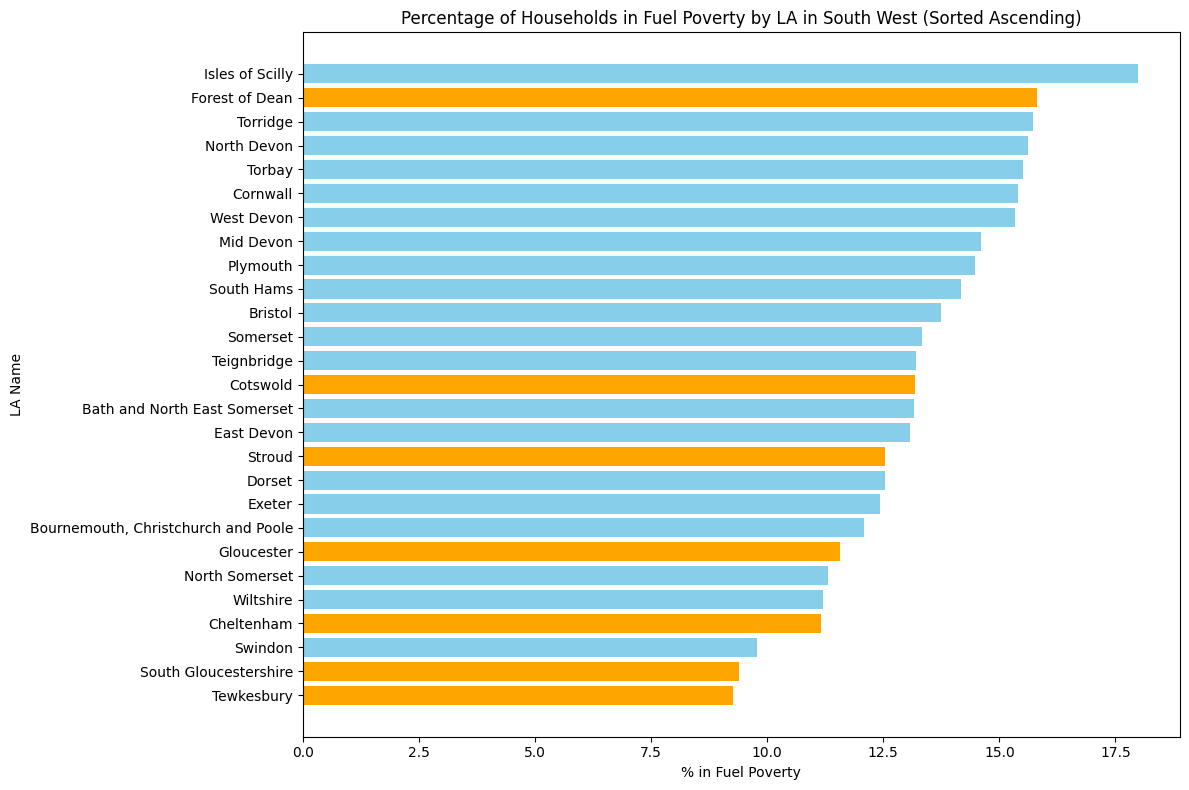

In [36]:
# prompt: from df get all with Region = South West, then groupby LA Name, add up Number of households and Number of households in fuel poverty, respectively
# then calculate % in fuel poverty
# finally generate a chart, and sorted by %, and highlight Cotswold, Forest of Dean, Gloucester, Cheltenham, Stroud, South Gloucestershire, Tewkesbury in orange

import matplotlib.pyplot as plt
# Filter for South West region
south_west_df = df[df['Region'] == 'South West']

# Group by LA Name and sum relevant columns
grouped_sw_df = south_west_df.groupby("LA Name").agg({
    "Number of households": "sum",
    "Number of households in fuel poverty": "sum"
}).reset_index()

# Calculate % in fuel poverty
grouped_sw_df["% in fuel poverty"] = (grouped_sw_df["Number of households in fuel poverty"] / grouped_sw_df["Number of households"]) * 100

# Sort by % in fuel poverty
sorted_sw_df = grouped_sw_df.sort_values(by='% in fuel poverty')

# Highlight specific LAs
highlight_las = ['Cotswold', 'Forest of Dean', 'Gloucester', 'Cheltenham', 'Stroud', 'South Gloucestershire', 'Tewkesbury']
colors = ['orange' if la in highlight_las else 'skyblue' for la in sorted_sw_df['LA Name']]

# Plot the bar chart
plt.figure(figsize=(12, 8))
plt.barh(sorted_sw_df['LA Name'], sorted_sw_df['% in fuel poverty'], color=colors)

# Add labels and title
plt.xlabel('% in Fuel Poverty')
plt.ylabel('LA Name')
plt.title('Percentage of Households in Fuel Poverty by LA in South West (Sorted Ascending)')
plt.tight_layout()

# Show the plot
plt.show()
